# Clean up fine-tuning steps

In [1]:
# standard lib
from pathlib import Path
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable

# parsers, for pdb, fasta, etc...
from Bio import SeqIO
import biotite.sequence as bseq
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_sequence, get_structure
from biotite.database import rcsb

# scientific libs
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist

# DL libs
import torch
import torchvision
import esm

from torch.utils.data import DataLoader
import torch.optim as optim

# graph libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# standard lib
import os
from pathlib import Path
import tqdm as tqdm 

# scientific libs
import numpy as np

# DL libs
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import esm
from esm.data import ESMStructuralSplitDataset

# graph libs
import matplotlib.pyplot as plt

In [3]:
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

for param in model.parameters():
    param.requires_grad = False

In [4]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")

Parameter name: embed_tokens.weight, Size: torch.Size([33, 320])
Parameter name: layers.0.self_attn.k_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.k_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.v_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.v_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.q_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.q_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.out_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.out_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.weight, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.bias, Size: torch.Size([320])
Parameter name: layers.0.fc1.weight, Size: torch.Size([1280, 320])
Parameter name: layers.0.fc1.bias, Size: torch.Size([1280])
Parameter name: layers.0.fc2.weight, Size: tor

In [4]:
# # Download structural holdout datasets
# for split_level in ['family', 'superfamily', 'fold']:
#     for cv_partition in ['0', '1', '2', '3', '4']:
#         esm_structural_train = ESMStructuralSplitDataset(
#             split_level=split_level, 
#             cv_partition=cv_partition, 
#             split='train', 
#             root_path = os.path.expanduser('~/.cache/torch/data/esm'),
#             download=True
#         )
#         esm_structural_valid = ESMStructuralSplitDataset(
#             split_level=split_level, 
#             cv_partition=cv_partition, 
#             split='valid', 
#             root_path = os.path.expanduser('~/.cache/torch/data/esm'),
#             download=True
#         )

In [5]:
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [5]:
# Freeze all parameters of the pretrained model
    
# Last layer output fatures decided from ESM-2's layers, emb_layer_norm_after?
# Modify last layer for our regression task

#model.final_layer = nn.Linear(in_features=320, out_features=1)

# model.final_layer = nn.Sequential(
#     nn.Linear(in_features=320, out_features=1),
#     nn.Sigmoid()
# )

# new_names = ['regression', 'activation']
# for i, (name, module) in enumerate(model.final_layer.named_children()):
#     module_name = new_names[i]
#     setattr(model.final_layer, module_name, module)
#     delattr(model.final_layer, name)

# for param in model.final_layer.parameters():
#     param.requires_grad = True

# nn.Sequential(
#     nn.Linear(320, 640),
#     nn.ReLU(),
#     nn.Linear(640, 320),
#     nn.ReLU(),
#     nn.Linear(320, 1))

#model.contact_head.regression.weight.requires_grad = True
#model.contact_head.regression.bias.requires_grad = True
#model.lm_head.bias.requires_grad = True

# Or freeze all the layers 11 steps from last?

# # Modify only the last layer for regression task. Maybe I should add a new layer ontop of the model instead 
# 

# # Set requires_grad=True only for the regression layer parameters to be trained

# for param in model.lm_head.parameters():
#     param.requires_grad = True

In [6]:
# Prepare data, optimizer, and objective/loss function
batch_converter = alphabet.get_batch_converter()

contact_threshold = 15

In [7]:
rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

Data point 433, MEKSIITQKIIAKAFKDLMQSNAYHQISVSDIMQTAKIRRQTFYNYFQNQEELLSWIFENDFAELINDNSD


In [8]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

print(outputs['contacts'])

tensor([[[6.1973e-17, 5.7741e-17, 2.4050e-06,  ..., 1.4139e-02,
          1.2235e-02, 8.7268e-03],
         [5.7741e-17, 1.9227e-02, 2.8078e-16,  ..., 1.6364e-02,
          1.5613e-02, 9.9549e-03],
         [2.4050e-06, 2.8078e-16, 2.4602e-03,  ..., 1.5384e-02,
          1.3392e-02, 8.4438e-03],
         ...,
         [1.4139e-02, 1.6364e-02, 1.5384e-02,  ..., 1.0782e-02,
          1.8171e-16, 5.8774e-07],
         [1.2235e-02, 1.5613e-02, 1.3392e-02,  ..., 1.8171e-16,
          2.1104e-02, 1.1959e-16],
         [8.7268e-03, 9.9549e-03, 8.4438e-03,  ..., 5.8774e-07,
          1.1959e-16, 3.3050e-02]]])


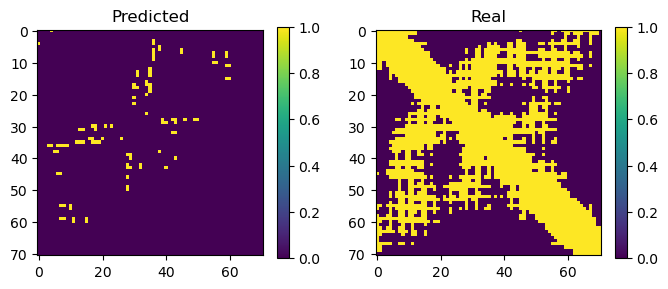

In [9]:
N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [10]:
print(model.contact_head.regression.weight)
print(model.contact_head.regression.bias)
print(model.emb_layer_norm_after.weight)
print(model.emb_layer_norm_after.bias)
print(model.lm_head.weight)
print(model.lm_head.bias)

Parameter containing:
tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   2.2631,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.5337,
          -3.6662,   0.0000,   0.0000,  -1.2137,   0.0000,   0.0000, -29.0679,
           0.7652,  -0.5132,   0.0000,   0.0000,   0.0000,   0.0000,  -0.4638,
           0.0000,  10.4998,   0.0000,   2.8318,   0.0000,   0.0000,  -4.2886,
           0.0000,   0.0000,   0.0000,   0.0000,   1.7150,   1.6285,  -9.3485,
           0.5058,   0.0000,   1.1955,   0.0000,   0.0000,   0.0000,   6.6861,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   1.2101,   0.0000,   0.0000,  -0.6021,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -2.1991,   1.8059,
           0.0000,   0.0000,  -0.1786,  -0.5292,   0.0000,  -0.0886,   1.4010,
          -0.3872,   0.0000,  

# Train fine-tuned layer and test 

In [11]:
# TESTING TRAINING

#model.contact_head.regression = nn.Linear(in_features=120, out_features=1)

# Set to update gradients during training

for param in model.contact_head.regression.parameters():
    param.requires_grad = True
    
for param in model.emb_layer_norm_after.parameters():
    param.requires_grad = True

for param in model.lm_head.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

embed_tokens.weight
contact_head.regression.weight
contact_head.regression.bias
emb_layer_norm_after.weight
emb_layer_norm_after.bias
lm_head.bias
lm_head.dense.weight
lm_head.dense.bias
lm_head.layer_norm.weight
lm_head.layer_norm.bias


In [17]:
from tqdm import tqdm

learning_rate = 0.001
               
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

#loss_fn = nn.BCELoss()
#loss_fn = nn.HuberLoss()
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.MSLE()

contact_threshold = 15

num_epochs = 200

for epoch in tqdm(range(num_epochs)):
    model.train()       
    total_loss = 0
    batch_num = 0
    
    for b in DataLoader(range(200), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
        inputs = batch_tokens
        targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
        optimizer.zero_grad()
        outputs = model(inputs, return_contacts=True)
        loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_num += 1
    
    average_loss = total_loss / batch_num
    print(f"Average Loss: {average_loss:.4f}")

  0%|          | 1/200 [00:30<1:41:47, 30.69s/it]

Average Loss: 0.0875


  1%|          | 2/200 [01:02<1:44:16, 31.60s/it]

Average Loss: 0.0872


  2%|▏         | 3/200 [01:34<1:44:24, 31.80s/it]

Average Loss: 0.0870


  2%|▏         | 4/200 [02:06<1:43:38, 31.73s/it]

Average Loss: 0.0869


  2%|▎         | 5/200 [02:38<1:43:08, 31.73s/it]

Average Loss: 0.0866


  3%|▎         | 6/200 [03:09<1:42:21, 31.66s/it]

Average Loss: 0.0865


  4%|▎         | 7/200 [03:41<1:41:48, 31.65s/it]

Average Loss: 0.0863


  4%|▍         | 8/200 [04:13<1:41:38, 31.76s/it]

Average Loss: 0.0862


  4%|▍         | 9/200 [04:46<1:41:58, 32.03s/it]

Average Loss: 0.0861


  5%|▌         | 10/200 [05:17<1:40:59, 31.89s/it]

Average Loss: 0.0859


  6%|▌         | 11/200 [05:49<1:40:16, 31.83s/it]

Average Loss: 0.0858


  6%|▌         | 12/200 [06:20<1:39:29, 31.75s/it]

Average Loss: 0.0856


  6%|▋         | 13/200 [06:52<1:39:04, 31.79s/it]

Average Loss: 0.0855


  7%|▋         | 14/200 [07:24<1:38:27, 31.76s/it]

Average Loss: 0.0855


  8%|▊         | 15/200 [07:56<1:37:51, 31.74s/it]

Average Loss: 0.0853


  8%|▊         | 16/200 [08:27<1:37:01, 31.64s/it]

Average Loss: 0.0851


  8%|▊         | 17/200 [08:58<1:36:16, 31.56s/it]

Average Loss: 0.0850


  9%|▉         | 18/200 [09:30<1:35:32, 31.50s/it]

Average Loss: 0.0849


 10%|▉         | 19/200 [10:01<1:35:06, 31.53s/it]

Average Loss: 0.0848


 10%|█         | 20/200 [10:33<1:34:28, 31.49s/it]

Average Loss: 0.0847


 10%|█         | 21/200 [11:04<1:34:02, 31.52s/it]

Average Loss: 0.0847


 11%|█         | 22/200 [11:36<1:33:18, 31.45s/it]

Average Loss: 0.0844


 12%|█▏        | 23/200 [12:07<1:32:56, 31.51s/it]

Average Loss: 0.0844


 12%|█▏        | 24/200 [12:39<1:32:25, 31.51s/it]

Average Loss: 0.0843


 12%|█▎        | 25/200 [13:10<1:31:57, 31.53s/it]

Average Loss: 0.0842


 13%|█▎        | 26/200 [13:42<1:31:26, 31.53s/it]

Average Loss: 0.0841


 14%|█▎        | 27/200 [14:14<1:30:54, 31.53s/it]

Average Loss: 0.0840


 14%|█▍        | 28/200 [14:45<1:30:21, 31.52s/it]

Average Loss: 0.0839


 14%|█▍        | 29/200 [15:16<1:29:47, 31.50s/it]

Average Loss: 0.0838


 15%|█▌        | 30/200 [15:48<1:29:13, 31.49s/it]

Average Loss: 0.0837


 16%|█▌        | 31/200 [16:19<1:28:43, 31.50s/it]

Average Loss: 0.0836


 16%|█▌        | 32/200 [16:51<1:28:12, 31.51s/it]

Average Loss: 0.0835


 16%|█▋        | 33/200 [17:22<1:27:42, 31.51s/it]

Average Loss: 0.0835


 17%|█▋        | 34/200 [17:54<1:27:14, 31.53s/it]

Average Loss: 0.0834


 18%|█▊        | 35/200 [18:26<1:26:40, 31.52s/it]

Average Loss: 0.0833


 18%|█▊        | 36/200 [18:57<1:26:08, 31.51s/it]

Average Loss: 0.0832


 18%|█▊        | 37/200 [19:29<1:25:58, 31.65s/it]

Average Loss: 0.0831


 19%|█▉        | 38/200 [20:01<1:26:02, 31.87s/it]

Average Loss: 0.0830


 20%|█▉        | 39/200 [20:33<1:25:05, 31.71s/it]

Average Loss: 0.0829


 20%|██        | 40/200 [21:04<1:24:27, 31.67s/it]

Average Loss: 0.0829


 20%|██        | 41/200 [21:36<1:23:39, 31.57s/it]

Average Loss: 0.0828


 21%|██        | 42/200 [22:09<1:24:53, 32.23s/it]

Average Loss: 0.0827


 22%|██▏       | 43/200 [22:41<1:23:57, 32.09s/it]

Average Loss: 0.0827


 22%|██▏       | 44/200 [23:13<1:22:50, 31.86s/it]

Average Loss: 0.0826


 22%|██▎       | 45/200 [23:44<1:22:01, 31.75s/it]

Average Loss: 0.0825


 23%|██▎       | 46/200 [24:16<1:21:27, 31.73s/it]

Average Loss: 0.0825


 24%|██▎       | 47/200 [24:47<1:20:48, 31.69s/it]

Average Loss: 0.0824


 24%|██▍       | 48/200 [25:19<1:20:04, 31.61s/it]

Average Loss: 0.0824


 24%|██▍       | 49/200 [25:50<1:19:34, 31.62s/it]

Average Loss: 0.0823


 25%|██▌       | 50/200 [26:22<1:19:05, 31.64s/it]

Average Loss: 0.0822


 26%|██▌       | 51/200 [26:53<1:18:23, 31.57s/it]

Average Loss: 0.0821


 26%|██▌       | 52/200 [27:25<1:18:00, 31.63s/it]

Average Loss: 0.0821


 26%|██▋       | 53/200 [27:58<1:18:20, 31.98s/it]

Average Loss: 0.0820


 27%|██▋       | 54/200 [28:29<1:17:14, 31.74s/it]

Average Loss: 0.0820


 28%|██▊       | 55/200 [29:01<1:16:35, 31.70s/it]

Average Loss: 0.0819


 28%|██▊       | 56/200 [29:33<1:16:05, 31.71s/it]

Average Loss: 0.0818


 28%|██▊       | 57/200 [30:04<1:15:15, 31.58s/it]

Average Loss: 0.0817


 29%|██▉       | 58/200 [30:35<1:14:38, 31.54s/it]

Average Loss: 0.0817


 30%|██▉       | 59/200 [31:07<1:14:02, 31.50s/it]

Average Loss: 0.0816


 30%|███       | 60/200 [31:38<1:13:32, 31.52s/it]

Average Loss: 0.0816


 30%|███       | 61/200 [32:10<1:13:07, 31.57s/it]

Average Loss: 0.0815


 31%|███       | 62/200 [32:42<1:12:52, 31.69s/it]

Average Loss: 0.0814


 32%|███▏      | 63/200 [33:13<1:12:09, 31.60s/it]

Average Loss: 0.0814


 32%|███▏      | 64/200 [33:45<1:11:34, 31.58s/it]

Average Loss: 0.0813


 32%|███▎      | 65/200 [34:16<1:11:05, 31.59s/it]

Average Loss: 0.0813


 33%|███▎      | 66/200 [34:48<1:10:30, 31.57s/it]

Average Loss: 0.0813


 34%|███▎      | 67/200 [35:20<1:09:58, 31.57s/it]

Average Loss: 0.0812


 34%|███▍      | 68/200 [35:51<1:09:27, 31.58s/it]

Average Loss: 0.0811


 34%|███▍      | 69/200 [36:23<1:08:55, 31.57s/it]

Average Loss: 0.0810


 35%|███▌      | 70/200 [36:54<1:08:25, 31.58s/it]

Average Loss: 0.0809


 36%|███▌      | 71/200 [37:26<1:07:57, 31.61s/it]

Average Loss: 0.0809


 36%|███▌      | 72/200 [37:57<1:07:23, 31.59s/it]

Average Loss: 0.0809


 36%|███▋      | 73/200 [38:29<1:06:49, 31.57s/it]

Average Loss: 0.0809


 37%|███▋      | 74/200 [39:00<1:06:13, 31.54s/it]

Average Loss: 0.0808


 38%|███▊      | 75/200 [39:32<1:05:40, 31.52s/it]

Average Loss: 0.0806


 38%|███▊      | 76/200 [40:04<1:05:27, 31.67s/it]

Average Loss: 0.0806


 38%|███▊      | 77/200 [40:35<1:04:50, 31.63s/it]

Average Loss: 0.0807


 39%|███▉      | 78/200 [41:07<1:04:17, 31.62s/it]

Average Loss: 0.0807


 40%|███▉      | 79/200 [41:39<1:04:08, 31.80s/it]

Average Loss: 0.0805


 40%|████      | 80/200 [42:11<1:03:22, 31.69s/it]

Average Loss: 0.0805


 40%|████      | 81/200 [42:42<1:02:45, 31.64s/it]

Average Loss: 0.0805


 41%|████      | 82/200 [43:14<1:02:04, 31.56s/it]

Average Loss: 0.0804


 42%|████▏     | 83/200 [43:45<1:01:32, 31.56s/it]

Average Loss: 0.0804


 42%|████▏     | 84/200 [44:17<1:01:01, 31.56s/it]

Average Loss: 0.0804


 42%|████▎     | 85/200 [44:48<1:00:26, 31.54s/it]

Average Loss: 0.0802


 43%|████▎     | 86/200 [45:20<59:51, 31.50s/it]  

Average Loss: 0.0802


 44%|████▎     | 87/200 [45:52<59:45, 31.73s/it]

Average Loss: 0.0801


 44%|████▍     | 88/200 [46:24<59:10, 31.70s/it]

Average Loss: 0.0801


 44%|████▍     | 89/200 [46:55<58:28, 31.61s/it]

Average Loss: 0.0802


 45%|████▌     | 90/200 [47:27<57:55, 31.60s/it]

Average Loss: 0.0801


 46%|████▌     | 91/200 [47:58<57:21, 31.57s/it]

Average Loss: 0.0800


 46%|████▌     | 92/200 [48:30<56:46, 31.55s/it]

Average Loss: 0.0799


 46%|████▋     | 93/200 [49:01<56:09, 31.49s/it]

Average Loss: 0.0800


 47%|████▋     | 94/200 [49:32<55:29, 31.42s/it]

Average Loss: 0.0799


 48%|████▊     | 95/200 [50:04<55:19, 31.61s/it]

Average Loss: 0.0797


 48%|████▊     | 96/200 [50:36<54:54, 31.68s/it]

Average Loss: 0.0797


 48%|████▊     | 97/200 [51:08<54:17, 31.63s/it]

Average Loss: 0.0797


 49%|████▉     | 98/200 [51:39<53:40, 31.58s/it]

Average Loss: 0.0797


 50%|████▉     | 99/200 [52:10<53:06, 31.55s/it]

Average Loss: 0.0797


 50%|█████     | 100/200 [52:42<52:31, 31.51s/it]

Average Loss: 0.0796


 50%|█████     | 101/200 [53:13<51:54, 31.46s/it]

Average Loss: 0.0796


 51%|█████     | 102/200 [53:45<51:25, 31.48s/it]

Average Loss: 0.0796


 52%|█████▏    | 103/200 [54:16<50:51, 31.45s/it]

Average Loss: 0.0796


 52%|█████▏    | 104/200 [54:48<50:28, 31.55s/it]

Average Loss: 0.0796


 52%|█████▎    | 105/200 [55:19<49:55, 31.54s/it]

Average Loss: 0.0795


 53%|█████▎    | 106/200 [55:51<49:32, 31.63s/it]

Average Loss: 0.0794


 54%|█████▎    | 107/200 [56:23<48:59, 31.60s/it]

Average Loss: 0.0793


 54%|█████▍    | 108/200 [56:54<48:26, 31.60s/it]

Average Loss: 0.0793


 55%|█████▍    | 109/200 [57:26<47:56, 31.61s/it]

Average Loss: 0.0792


 55%|█████▌    | 110/200 [57:58<47:25, 31.61s/it]

Average Loss: 0.0792


 56%|█████▌    | 111/200 [58:29<46:50, 31.58s/it]

Average Loss: 0.0792


 56%|█████▌    | 112/200 [59:01<46:17, 31.57s/it]

Average Loss: 0.0792


 56%|█████▋    | 113/200 [59:32<45:43, 31.54s/it]

Average Loss: 0.0791


 57%|█████▋    | 114/200 [1:00:04<45:18, 31.61s/it]

Average Loss: 0.0791


 57%|█████▊    | 115/200 [1:00:35<44:42, 31.56s/it]

Average Loss: 0.0792


 58%|█████▊    | 116/200 [1:01:07<44:12, 31.57s/it]

Average Loss: 0.0790


 58%|█████▊    | 117/200 [1:01:39<43:40, 31.57s/it]

Average Loss: 0.0791


 59%|█████▉    | 118/200 [1:02:10<43:06, 31.54s/it]

Average Loss: 0.0789


 60%|█████▉    | 119/200 [1:02:42<42:33, 31.53s/it]

Average Loss: 0.0789


 60%|██████    | 120/200 [1:03:13<41:59, 31.49s/it]

Average Loss: 0.0788


 60%|██████    | 121/200 [1:03:44<41:27, 31.49s/it]

Average Loss: 0.0788


 61%|██████    | 122/200 [1:04:16<40:59, 31.53s/it]

Average Loss: 0.0788


 62%|██████▏   | 123/200 [1:04:47<40:23, 31.48s/it]

Average Loss: 0.0788


 62%|██████▏   | 124/200 [1:05:19<39:58, 31.56s/it]

Average Loss: 0.0789


 62%|██████▎   | 125/200 [1:05:51<39:24, 31.53s/it]

Average Loss: 0.0788


 63%|██████▎   | 126/200 [1:06:22<38:55, 31.56s/it]

Average Loss: 0.0787


 64%|██████▎   | 127/200 [1:06:55<38:40, 31.79s/it]

Average Loss: 0.0787


 64%|██████▍   | 128/200 [1:07:27<38:15, 31.88s/it]

Average Loss: 0.0786


 64%|██████▍   | 129/200 [1:07:58<37:34, 31.76s/it]

Average Loss: 0.0786


 65%|██████▌   | 130/200 [1:08:30<36:55, 31.65s/it]

Average Loss: 0.0785


 66%|██████▌   | 131/200 [1:09:01<36:19, 31.59s/it]

Average Loss: 0.0787


 66%|██████▌   | 132/200 [1:09:32<35:43, 31.52s/it]

Average Loss: 0.0786


 66%|██████▋   | 133/200 [1:10:04<35:15, 31.57s/it]

Average Loss: 0.0785


 67%|██████▋   | 134/200 [1:10:35<34:40, 31.53s/it]

Average Loss: 0.0784


 68%|██████▊   | 135/200 [1:11:07<34:09, 31.54s/it]

Average Loss: 0.0784


 68%|██████▊   | 136/200 [1:11:39<33:40, 31.57s/it]

Average Loss: 0.0786


 68%|██████▊   | 137/200 [1:12:10<33:06, 31.53s/it]

Average Loss: 0.0785


 69%|██████▉   | 138/200 [1:12:42<32:39, 31.61s/it]

Average Loss: 0.0783


 70%|██████▉   | 139/200 [1:13:13<32:03, 31.54s/it]

Average Loss: 0.0782


 70%|███████   | 140/200 [1:13:45<31:31, 31.53s/it]

Average Loss: 0.0782


 70%|███████   | 141/200 [1:14:16<31:01, 31.55s/it]

Average Loss: 0.0782


 71%|███████   | 142/200 [1:14:48<30:34, 31.63s/it]

Average Loss: 0.0782


 72%|███████▏  | 143/200 [1:15:20<30:01, 31.60s/it]

Average Loss: 0.0781


 72%|███████▏  | 144/200 [1:15:51<29:28, 31.58s/it]

Average Loss: 0.0782


 72%|███████▎  | 145/200 [1:16:23<28:56, 31.57s/it]

Average Loss: 0.0782


 73%|███████▎  | 146/200 [1:16:55<28:26, 31.60s/it]

Average Loss: 0.0781


 74%|███████▎  | 147/200 [1:17:26<27:52, 31.56s/it]

Average Loss: 0.0783


 74%|███████▍  | 148/200 [1:17:58<27:21, 31.57s/it]

Average Loss: 0.0781


 74%|███████▍  | 149/200 [1:18:29<26:47, 31.53s/it]

Average Loss: 0.0780


 75%|███████▌  | 150/200 [1:19:01<26:16, 31.53s/it]

Average Loss: 0.0781


 76%|███████▌  | 151/200 [1:19:32<25:42, 31.48s/it]

Average Loss: 0.0779


 76%|███████▌  | 152/200 [1:20:03<25:11, 31.49s/it]

Average Loss: 0.0779


 76%|███████▋  | 153/200 [1:20:35<24:36, 31.41s/it]

Average Loss: 0.0779


 77%|███████▋  | 154/200 [1:21:07<24:17, 31.70s/it]

Average Loss: 0.0779


 78%|███████▊  | 155/200 [1:21:39<23:44, 31.66s/it]

Average Loss: 0.0780


 78%|███████▊  | 156/200 [1:22:12<23:42, 32.32s/it]

Average Loss: 0.0779


 78%|███████▊  | 157/200 [1:22:44<23:01, 32.12s/it]

Average Loss: 0.0780


 79%|███████▉  | 158/200 [1:23:15<22:18, 31.88s/it]

Average Loss: 0.0779


 80%|███████▉  | 159/200 [1:23:47<21:42, 31.77s/it]

Average Loss: 0.0778


 80%|████████  | 160/200 [1:24:18<21:05, 31.65s/it]

Average Loss: 0.0777


 80%|████████  | 161/200 [1:24:50<20:33, 31.62s/it]

Average Loss: 0.0778


 81%|████████  | 162/200 [1:25:21<20:00, 31.58s/it]

Average Loss: 0.0777


 82%|████████▏ | 163/200 [1:25:53<19:27, 31.56s/it]

Average Loss: 0.0777


 82%|████████▏ | 164/200 [1:26:24<18:56, 31.56s/it]

Average Loss: 0.0777


 82%|████████▎ | 165/200 [1:26:56<18:21, 31.47s/it]

Average Loss: 0.0777


 83%|████████▎ | 166/200 [1:27:27<17:48, 31.44s/it]

Average Loss: 0.0777


 84%|████████▎ | 167/200 [1:27:58<17:16, 31.41s/it]

Average Loss: 0.0777


 84%|████████▍ | 168/200 [1:28:30<16:44, 31.38s/it]

Average Loss: 0.0775


 84%|████████▍ | 169/200 [1:29:01<16:09, 31.28s/it]

Average Loss: 0.0775


 85%|████████▌ | 170/200 [1:29:32<15:41, 31.38s/it]

Average Loss: 0.0774


 86%|████████▌ | 171/200 [1:30:04<15:09, 31.36s/it]

Average Loss: 0.0775


 86%|████████▌ | 172/200 [1:30:35<14:39, 31.40s/it]

Average Loss: 0.0775


 86%|████████▋ | 173/200 [1:31:07<14:08, 31.42s/it]

Average Loss: 0.0776


 87%|████████▋ | 174/200 [1:31:38<13:36, 31.41s/it]

Average Loss: 0.0775


 88%|████████▊ | 175/200 [1:32:09<13:03, 31.35s/it]

Average Loss: 0.0774


 88%|████████▊ | 176/200 [1:32:41<12:33, 31.39s/it]

Average Loss: 0.0775


 88%|████████▊ | 177/200 [1:33:12<12:00, 31.33s/it]

Average Loss: 0.0774


 89%|████████▉ | 178/200 [1:33:43<11:29, 31.33s/it]

Average Loss: 0.0773


 90%|████████▉ | 179/200 [1:34:15<10:59, 31.40s/it]

Average Loss: 0.0775


 90%|█████████ | 180/200 [1:34:46<10:27, 31.39s/it]

Average Loss: 0.0773


 90%|█████████ | 181/200 [1:35:17<09:55, 31.36s/it]

Average Loss: 0.0772


 91%|█████████ | 182/200 [1:35:49<09:24, 31.37s/it]

Average Loss: 0.0772


 92%|█████████▏| 183/200 [1:36:20<08:53, 31.38s/it]

Average Loss: 0.0773


 92%|█████████▏| 184/200 [1:36:52<08:22, 31.40s/it]

Average Loss: 0.0772


 92%|█████████▎| 185/200 [1:37:23<07:49, 31.32s/it]

Average Loss: 0.0772


 93%|█████████▎| 186/200 [1:37:54<07:19, 31.36s/it]

Average Loss: 0.0774


 94%|█████████▎| 187/200 [1:38:26<06:47, 31.33s/it]

Average Loss: 0.0772


 94%|█████████▍| 188/200 [1:38:57<06:15, 31.32s/it]

Average Loss: 0.0771


 94%|█████████▍| 189/200 [1:39:28<05:43, 31.27s/it]

Average Loss: 0.0772


 95%|█████████▌| 190/200 [1:40:00<05:13, 31.35s/it]

Average Loss: 0.0772


 96%|█████████▌| 191/200 [1:40:31<04:41, 31.31s/it]

Average Loss: 0.0770


 96%|█████████▌| 192/200 [1:41:02<04:10, 31.32s/it]

Average Loss: 0.0771


 96%|█████████▋| 193/200 [1:41:33<03:38, 31.24s/it]

Average Loss: 0.0770


 97%|█████████▋| 194/200 [1:42:04<03:07, 31.17s/it]

Average Loss: 0.0769


 98%|█████████▊| 195/200 [1:42:35<02:35, 31.15s/it]

Average Loss: 0.0769


 98%|█████████▊| 196/200 [1:43:06<02:04, 31.14s/it]

Average Loss: 0.0769


 98%|█████████▊| 197/200 [1:43:37<01:33, 31.12s/it]

Average Loss: 0.0770


 99%|█████████▉| 198/200 [1:44:09<01:02, 31.19s/it]

Average Loss: 0.0771


100%|█████████▉| 199/200 [1:44:40<00:31, 31.28s/it]

Average Loss: 0.0768


100%|██████████| 200/200 [1:45:12<00:00, 31.56s/it]

Average Loss: 0.0769


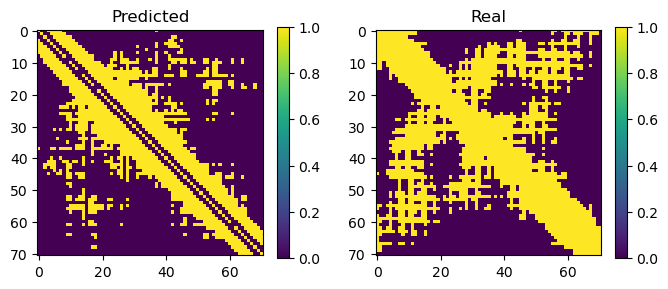

In [13]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

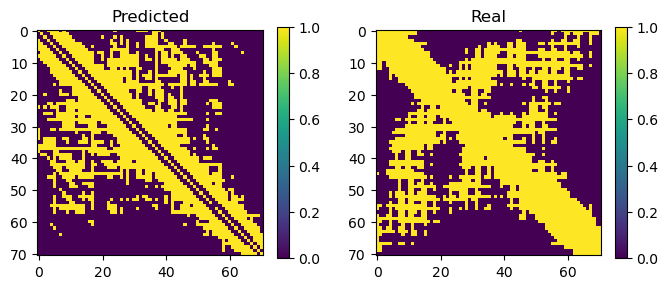

In [18]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [ ]:
print(model.contact_head.regression.weight)
print(model.contact_head.regression.bias)
print(model.emb_layer_norm_after.weight)
print(model.emb_layer_norm_after.bias)
print(model.lm_head.weight)
print(model.lm_head.bias)

# Testing pandas DF and dataloader system for more batches

In [20]:
# from torch.utils.data import TensorDataset, DataLoader

# batch_tokens_list = []
# contact_list = []

# contact_threshold = 15

# # Iterate over the train_dataset
# for i in range(300):
#     batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"])])
#     targets = torch.tensor(train_dataset[i]['dist'] < contact_threshold)

#     # Append the batch tokens and target dist to the respective lists
#     batch_tokens_list.append(batch_tokens)
#     contact_list.append(targets)

# # Create the dataframe from the lists
# dataset = pd.DataFrame({'inputs': batch_tokens_list, 'targets': contact_list})

In [31]:
# from torch.utils.data import TensorDataset, DataLoader

# seqs_list = []
# contact_list = []

# contact_threshold = 15

# for i in range(len(train_dataset)):
#     seqs = train_dataset[i]["seq"]
#     targets = torch.tensor(train_dataset[i]['dist'] < contact_threshold)

#     seqs_list.append(seqs)
#     contact_list.append(targets)

# dataset = pd.DataFrame({'seqs': seqs_list, 'targets': contact_list})

In [32]:
# dataset.head()

,seqs,targets
0,MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYL...,"[[tensor(True), tensor(True), tensor(True), te..."
1,KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHL...,"[[tensor(True), tensor(True), tensor(True), te..."
2,GQRHIKIREIIMSNDIETQDELVDRLREAGFNVTQATVSRDIKEMQ...,"[[tensor(True), tensor(True), tensor(True), te..."
3,MNKGQRHIKIREIITSNEIETQDELVDMLKQDGYKVTQATVSRDIK...,"[[tensor(False), tensor(False), tensor(False),..."
4,RHIKIREIIANNDVETQDELVEQLKAAGYNVTQATVSRDIKELHLV...,"[[tensor(True), tensor(True), tensor(True), te..."


In [ ]:
# batch_size = 8

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# learning_rate = 0.001

# optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# loss_fn = nn.SmoothL1Loss()

# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     batch_num = 0

#     for batch in dataloader:
#         batch_labels, batch_strs, batch_tokens = batch_converter(batch['seqs'])
#         inputs = batch_tokens
#         optimizer.zero_grad()
#         outputs = model(inputs, return_contacts=True)
#         loss = loss_fn(outputs['contacts'], batch['targets'])
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#         batch_num += 1

#     average_loss = total_loss / batch_num
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

# Keep on getting key errors with pandas

# Testing arena

In [25]:
# for param in model.parameters():
#     param.requires_grad = False

# model.final_layer = nn.Sequential(
#     nn.Linear(in_features=320, out_features=1),
#     nn.Sigmoid()
# )

# for param in model.final_layer.parameters():
#     param.requires_grad = True

learning_rate = 0.001
               
#optimizer = optim.Adam([{'params': model.final_layer.parameters(), 'lr': learning_rate}], lr=learning_rate)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
#optimizer = optim.Adam(model.final_layer.parameters(), lr=learning_rate)

#loss_fn = nn.BCELoss()
#loss_fn = nn.HuberLoss()
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.MSELoss()
#loss_fn = nn.MSLE()

contact_threshold = 15

num_epochs = 25

for epoch in range(num_epochs):
    model.train()       
    total_loss = 0
    batch_num = 0
    
    for b in DataLoader(range(50), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
        inputs = batch_tokens
        targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
        optimizer.zero_grad()
        outputs = model(inputs, return_contacts=True)
        loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_num += 1
    
    average_loss = total_loss / batch_num
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/50, Average Loss: 2.2652
Epoch 2/50, Average Loss: 2.0756
Epoch 3/50, Average Loss: 2.0049
Epoch 4/50, Average Loss: 1.9411
Epoch 5/50, Average Loss: 1.9085
Epoch 6/50, Average Loss: 1.8877
Epoch 7/50, Average Loss: 1.8798
Epoch 8/50, Average Loss: 1.8697
Epoch 9/50, Average Loss: 1.8658
Epoch 10/50, Average Loss: 1.8603
Epoch 11/50, Average Loss: 1.8579
Epoch 12/50, Average Loss: 1.8540
Epoch 13/50, Average Loss: 1.8527
Epoch 14/50, Average Loss: 1.8491
Epoch 15/50, Average Loss: 1.8480
Epoch 16/50, Average Loss: 1.8445
Epoch 17/50, Average Loss: 1.8437
Epoch 18/50, Average Loss: 1.8415
Epoch 19/50, Average Loss: 1.8395
Epoch 20/50, Average Loss: 1.8323
Epoch 21/50, Average Loss: 1.8280
Epoch 22/50, Average Loss: 1.8243
Epoch 23/50, Average Loss: 1.8177
Epoch 24/50, Average Loss: 1.8136
Epoch 25/50, Average Loss: 1.8085
Epoch 26/50, Average Loss: 1.8049
Epoch 27/50, Average Loss: 1.7969
Epoch 28/50, Average Loss: 1.7937
Epoch 29/50, Average Loss: 1.7863
Epoch 30/50, Average Lo

In [ ]:
print(model.contact_head.regression.weight)
print(model.contact_head.regression.bias)
print(model.emb_layer_norm_after.weight)
print(model.emb_layer_norm_after.bias)
print(model.lm_head.weight)
print(model.lm_head.bias)

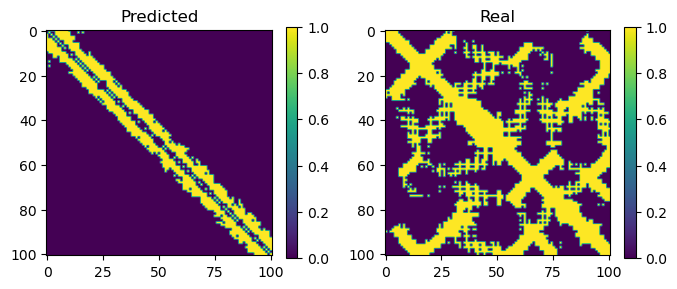

In [26]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
#N = (batch_tokens != alphabet.padding_idx).sum(1)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)#rand_target['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [17]:
# # train_dataloader = DataLoader(batch_tokens, batch_size=16, shuffle=True)
# train_dataloader = DataLoader(batch_labels[:6], batch_size=2, shuffle=True)

# learning_rate = 0.001
               
# # Maybe try "AdamW" with weight decay
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# # Set objective function. Huber less sensitive to outliers than MSEloss, maybe try MSE or MAE as well?        
# loss_fn = nn.SmoothL1Loss()

# contact_threshold = 15

# # Training loop
# num_epochs = 10
               
# for epoch in range(num_epochs):
#     model.train()
               
#     # Initialise loss for each epoch   
#     total_loss = 0
    
# #     for b in DataLoader(range(len(train_dataset)), batch_size=1, shuffle=True):
#     for b in DataLoader(range(50), batch_size=1, shuffle=True):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
#         # Sequence inputs - IndexError: too many indices for tensor of dimension 2
#         inputs = batch_tokens
#         # contacts
#         targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
#         # Clear gradients for each epoch
#         optimizer.zero_grad()
#         # Output predictions for batch 
#         outputs = model(inputs, return_contacts=True)
#         # Calculates Huber loss between predictions and true values
#         loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
#         # Pool loss values from each batch
#         total_loss += loss.item()
#         # Backpropagation
#         loss.backward()
#         # Updates last layer parameters to reduce loss
#         optimizer.step()
    
#     # Print loss per batch for the epoch 
#     average_loss = total_loss / len(train_dataloader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/10, Average Loss: 6.1310
Epoch 2/10, Average Loss: 5.8396
Epoch 3/10, Average Loss: 5.6010
Epoch 4/10, Average Loss: 5.4103
Epoch 5/10, Average Loss: 5.2562
Epoch 6/10, Average Loss: 5.1326
Epoch 7/10, Average Loss: 5.0320
Epoch 8/10, Average Loss: 4.9518
Epoch 9/10, Average Loss: 4.8842
Epoch 10/10, Average Loss: 4.8299


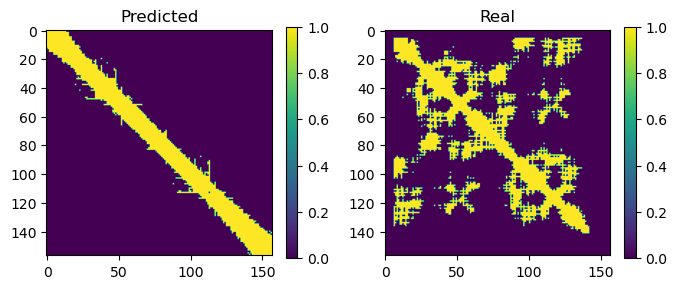

In [19]:
# batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
# rand_target_c = rand_target['dist'] < contact_threshold

# outputs = model(batch_tokens, return_contacts=True)

# N = len(batch_strs[0])
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'] < contact_threshold)
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

In [10]:
# #train_dataloader = DataLoader(batch_labels[:6], batch_size=2, shuffle=True)

# learning_rate = 0.001
               
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
                     
# loss_fn = nn.SmoothL1Loss()

# contact_threshold = 15

# num_epochs = 10
      
# num_iterations = 0     
    
# for epoch in range(num_epochs):
#     model.train()       
#     total_loss = 0
    
#     # Train last layer regression on 100 6015 sequences
#     for b in DataLoader(range(350), batch_size=8, shuffle=True):
#         batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
#         inputs = batch_tokens
#         targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
#         optimizer.zero_grad()
#         outputs = model(inputs, return_contacts=True)
#         loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         num_iterations += 1
    
#     average_loss = total_loss / num_iterations
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

C:\Users\neil_\AppData\Local\Temp\ipykernel_26520\4205689614.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))


Epoch 1/20, Average Loss: 0.1107
Epoch 2/20, Average Loss: 0.0929
Epoch 3/20, Average Loss: 0.0859
Epoch 4/20, Average Loss: 0.0828
Epoch 5/20, Average Loss: 0.0813
Epoch 6/20, Average Loss: 0.0805
Epoch 7/20, Average Loss: 0.0800
Epoch 8/20, Average Loss: 0.0797
Epoch 9/20, Average Loss: 0.0795
Epoch 10/20, Average Loss: 0.0793
Epoch 11/20, Average Loss: 0.0791
Epoch 12/20, Average Loss: 0.0789
Epoch 13/20, Average Loss: 0.0788
Epoch 14/20, Average Loss: 0.0786
Epoch 15/20, Average Loss: 0.0785
Epoch 16/20, Average Loss: 0.0784
Epoch 17/20, Average Loss: 0.0782
Epoch 18/20, Average Loss: 0.0781
Epoch 19/20, Average Loss: 0.0780
Epoch 20/20, Average Loss: 0.0779


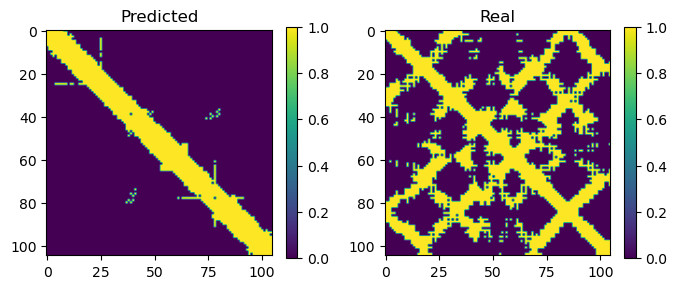

In [11]:
# batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
# rand_target_c = rand_target['dist'] < contact_threshold

# outputs = model(batch_tokens, return_contacts=True)

# N = len(batch_strs[0])
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target['dist'] < contact_threshold)
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

In [15]:
#train_dataloader = DataLoader(batch_labels[:6], batch_size=2, shuffle=True)

learning_rate = 0.001
               
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
                     
loss_fn = nn.SmoothL1Loss()

contact_threshold = 15

num_epochs = 10
      
num_iterations = 0     
    
for epoch in range(num_epochs):
    model.train()       
    total_loss = 0
    
    # Train last layer regression on 100 6015 sequences
    for b in DataLoader(range(350), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
        inputs = batch_tokens
        targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
        optimizer.zero_grad()
        outputs = model(inputs, return_contacts=True)
        loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_iterations += 1
    
    average_loss = total_loss / num_iterations
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/10, Average Loss: 0.1098
Epoch 2/10, Average Loss: 0.0453
Epoch 3/10, Average Loss: 0.0280
Epoch 4/10, Average Loss: 0.0203
Epoch 5/10, Average Loss: 0.0160
Epoch 6/10, Average Loss: 0.0132
Epoch 7/10, Average Loss: 0.0113
Epoch 8/10, Average Loss: 0.0099
Epoch 9/10, Average Loss: 0.0087
Epoch 10/10, Average Loss: 0.0078


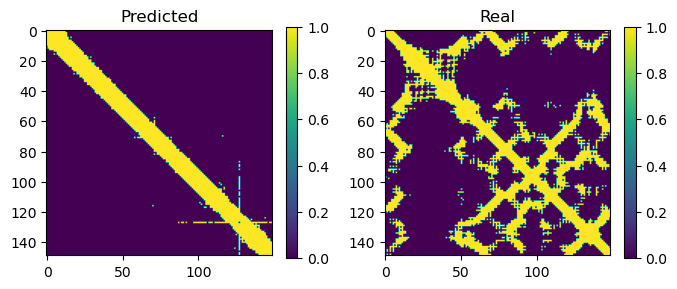

In [16]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [18]:
#train_dataloader = DataLoader(batch_labels[:6], batch_size=2, shuffle=True)

learning_rate = 0.001
               
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
                     
loss_fn = nn.MSELoss()

contact_threshold = 15

num_epochs = 10
      
num_iterations = 0     
    
for epoch in range(num_epochs):
    model.train()       
    total_loss = 0
    
    # Train last layer regression on 100 6015 sequences
    for b in DataLoader(range(350), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
        inputs = batch_tokens
        targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
        optimizer.zero_grad()
        outputs = model(inputs, repr_layers=[33], return_contacts=True)
        loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_iterations += 1
    
    average_loss = total_loss / num_iterations
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/10, Average Loss: 0.1565
Epoch 2/10, Average Loss: 0.0781
Epoch 3/10, Average Loss: 0.0519
Epoch 4/10, Average Loss: 0.0389
Epoch 5/10, Average Loss: 0.0310
Epoch 6/10, Average Loss: 0.0258
Epoch 7/10, Average Loss: 0.0221
Epoch 8/10, Average Loss: 0.0193
Epoch 9/10, Average Loss: 0.0171
Epoch 10/10, Average Loss: 0.0154


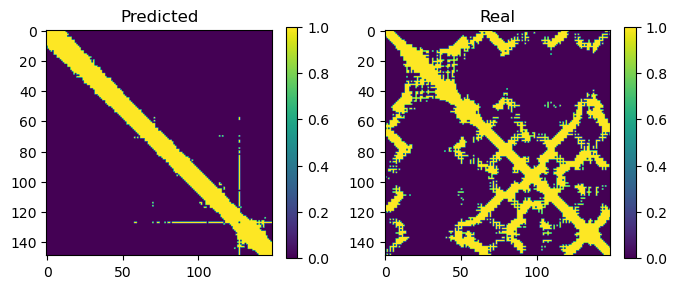

In [19]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, repr_layers=[33], return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [20]:
learning_rate = 0.001
               
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
                     
loss_fn = nn.MSELoss()

contact_threshold = 15

num_epochs = 10
      
num_iterations = 0     
    
for epoch in range(num_epochs):
    model.train()       
    total_loss = 0
    
    # Train last layer regression on 100 6015 sequences
    for b in DataLoader(range(350), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, train_dataset[i]["seq"]) for i in b])
        inputs = batch_tokens
        targets = [train_dataset[i]['dist'] < contact_threshold for i in b]
        optimizer.zero_grad()
        outputs = model(inputs, repr_layers=[33], return_contacts=True)
        loss = loss_fn(outputs['contacts'], torch.tensor(targets, dtype=torch.float32))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        num_iterations += 1
    
    average_loss = total_loss / num_iterations
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")

Epoch 1/10, Average Loss: 0.1538
Epoch 2/10, Average Loss: 0.0768
Epoch 3/10, Average Loss: 0.0511
Epoch 4/10, Average Loss: 0.0383
Epoch 5/10, Average Loss: 0.0306
Epoch 6/10, Average Loss: 0.0255
Epoch 7/10, Average Loss: 0.0218
Epoch 8/10, Average Loss: 0.0191
Epoch 9/10, Average Loss: 0.0169
Epoch 10/10, Average Loss: 0.0152


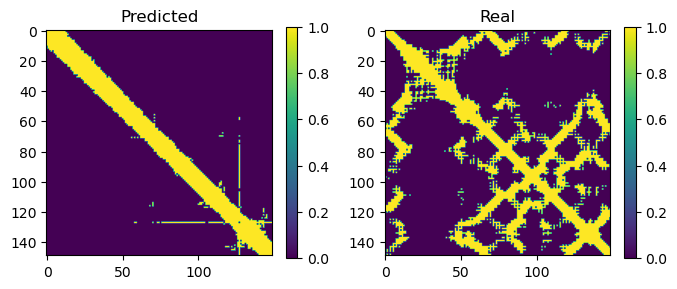

In [21]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, repr_layers=[33], return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

Parameter name: embed_tokens.weight, Size: torch.Size([33, 320])
Parameter name: layers.0.self_attn.k_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.k_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.v_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.v_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.q_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.q_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.out_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.out_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.weight, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.bias, Size: torch.Size([320])
Parameter name: layers.0.fc1.weight, Size: torch.Size([1280, 320])
Parameter name: layers.0.fc1.bias, Size: torch.Size([1280])
Parameter name: layers.0.fc2.weight, Size: tor

In [1]:
!pip install fair-esm

import torch
import os
import gc
import esm
from esm import pretrained

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"

# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Load pretrained model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

# Check layers in architecture
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Size: {param.size()}")

# Set device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Parameter name: embed_tokens.weight, Size: torch.Size([33, 320])
Parameter name: layers.0.self_attn.k_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.k_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.v_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.v_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.q_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.q_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn.out_proj.weight, Size: torch.Size([320, 320])
Parameter name: layers.0.self_attn.out_proj.bias, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.weight, Size: torch.Size([320])
Parameter name: layers.0.self_attn_layer_norm.bias, Size: torch.Size([320])
Parameter name: layers.0.fc1.weight, Size: torch.Size([1280, 320])
Parameter name: layers.0.fc1.bias, Size: torch.Size([1280])
Parameter name: layers.0.fc2.weight, Size: tor

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0-5): 6 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=120, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((320,), eps=1e-05, elementwis

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
import torch.nn as nn
from pathlib import Path
from esm.data import ESMStructuralSplitDataset
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Download structural holdout datasets (already downloaded)

# for split_level in ['family', 'superfamily', 'fold']:
#     for cv_partition in ['0', '1', '2', '3', '4']:
#         esm_structural_train = ESMStructuralSplitDataset(
#             split_level=split_level, 
#             cv_partition=cv_partition, 
#             split='train', 
#             root_path = os.path.expanduser('~/.cache/torch/data/esm'),
#             download=True
#         )
#         esm_structural_valid = ESMStructuralSplitDataset(
#             split_level=split_level, 
#             cv_partition=cv_partition, 
#             split='valid', 
#             root_path = os.path.expanduser('~/.cache/torch/data/esm'),
#             download=True
#         )

# Set train and validation datasets from the ESM library
esm_structural_train = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='0', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

esm_structural_valid = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='0', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

# Check how many entries in dictionary
print(len(esm_structural_train))
print(len(esm_structural_valid))

# Training dataset downloaded from ESMStructuralSplitDataset already split into training and validation sets
train_dataset = esm_structural_train
valid_dataset = esm_structural_valid

12031
3266


In [3]:
# Use ESM-2's batch converter for tokneisation/padding
batch_converter = alphabet.get_batch_converter()
# Pull only the sequences in entire dataset for conversion
train_data = [(i, train_dataset[i]["seq"]) for i in range(len(train_dataset))]
# Tokenise sequences
batch_labels, batch_strs, batch_tokens = batch_converter(train_data)

In [4]:
# Put batch token tensor in a tensor dataset object
training_dataset = TensorDataset(batch_tokens)

In [5]:
# Check the batch tensor dimensions
print(batch_tokens)
print(batch_tokens.shape)
print(type(batch_tokens))
print(len(batch_tokens))

tensor([[ 0, 20, 21,  ...,  1,  1,  1],
        [ 0,  8, 20,  ...,  1,  1,  1],
        [ 0, 20, 16,  ...,  1,  1,  1],
        ...,
        [ 0, 21, 19,  ...,  1,  1,  1],
        [ 0, 20,  6,  ...,  1,  1,  1],
        [ 0, 20, 10,  ...,  1,  1,  1]])
torch.Size([12031, 884])
<class 'torch.Tensor'>
12031


In [6]:
print(training_dataset)
print(type(training_dataset))
print(len(training_dataset))

<class 'torch.utils.data.dataset.TensorDataset'>
12031


In [7]:
# gc.collect()
# torch.cuda.empty_cache()

# # Not sure whether to use token_representaions for output in the loss function?
# with torch.no_grad():
#     results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
# token_representations = results["representations"][33].to(device)

In [7]:
# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

# Last layer output fatures decided from ESM-2's layers, emb_layer_norm_after?
hidden_size = 320

# Modify last layer for our regression task
model.final_layer = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features=hidden_size, out_features=160),
    nn.ReLU(),
    nn.Linear(in_features=160, out_features=80),
    nn.ReLU(),
    nn.Linear(in_features=80, out_features=1),
)

# Enable gradient computation for the parameters in the final_layer
for param in model.final_layer.parameters():
    param.requires_grad = True

In [ ]:
# # Removed dataloader due to dictionary and list issues in training loop, not enough memory for CUDA to process full dataset of 12031
# # Clear cache
# gc.collect()
# torch.cuda.empty_cache()

# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = nn.SmoothL1Loss()

# num_epochs = 10

# for epoch in range(num_epochs):
#     gc.collect()
#     torch.cuda.empty_cache()
#     model.train()
#     total_loss = 0
#     running_loss = 0.0
#     inputs = batch_tokens.to(device)
#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = loss_fn(outputs, inputs)
#     loss.backward()
#     optimizer.step()
#     running_loss += loss.item()
#     total_loss += loss.item()
#     gc.collect()
#     torch.cuda.empty_cache()

#     average_loss = total_loss / len(batch_tokens)
#     print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")
#     print(f"Epoch {epoch+1} loss: {running_loss:.4f}")

In [8]:
# Clear cache
gc.collect()
torch.cuda.empty_cache()


learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#loss_fn = nn.MSELoss()
loss_fn = nn.SmoothL1Loss().to(device)

num_epochs = 10

# Set a low batch size for memory efficency
batch_size = 2

train_dataloader = DataLoader(batch_tokens, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    running_loss = 0.0

    for batch_tokens in train_dataloader:

        #batch_tokens = torch.stack(batch_token_list).to(device) list of tensors issue
        
        # Reshape tensor to 2D shape [batch_size, sequence_length] to pass assert tokens.ndim == 2
        inputs = batch_tokens.reshape(batch_size, -1).to(device)
        
        optimizer.zero_grad()
        
        # Access contact representations in dictionary for output? 
        with torch.no_grad():
            results = model(inputs, repr_layers=[33], return_contacts=True)
        
        outputs = results["representations"][33].to(device)
        
        #outputs = model(inputs)
        #output_tensor = outputs["logits"] # what tensor to access for loss function, maybe "logits"?
        
        # What is the origin of the loss input size (torch.Size([8, 884, 33])) is this from the model embedding or lm_head?
        # Parameter name: embed_tokens.weight, Size: torch.Size([33, 320])
        # Parameter name: lm_head.bias, Size: torch.Size([33])
        # RuntimeError: The size of tensor a (33) must match the size of tensor b (884) at non-singleton dimension 2
        # Using a target size (torch.Size([8, 884]))
        
        #loss = loss_fn(output_tensor, inputs) # AttributeError: 'dict' object has no attribute 'size' - I accessed logits instead, does this need to be processed i.e. softmax?
        
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss += loss.item()
        gc.collect()
        torch.cuda.empty_cache()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")
    print(f"Epoch {epoch+1} loss: {running_loss:.4f}")
    
gc.collect()
torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 714.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 14.15 MiB free; 2.87 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Testing AMP for memory efficency

In [9]:
gc.collect()
torch.cuda.empty_cache()

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.SmoothL1Loss().to(device)

num_epochs = 10

batch_size = 2

train_dataloader = DataLoader(batch_tokens, batch_size=batch_size, shuffle=True)

# Set automatic mixed precision - gradient scaler to help with memory issues
scaler = GradScaler()

for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    running_loss = 0.0

    for batch_tokens in train_dataloader:
        inputs = batch_tokens.reshape(batch_size, -1).to(device)

        optimizer.zero_grad()
        
        # Train with AMP autocast to use less memory
        with autocast():
            results = model(inputs, repr_layers=[33], return_contacts=True)
            outputs = results["representations"][33].to(device)
            #outputs = results["contacts"][33].to(device)
            loss = loss_fn(outputs, inputs)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        total_loss += loss.item()
        gc.collect()
        torch.cuda.empty_cache()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {average_loss:.4f}")
    print(f"Epoch {epoch+1} loss: {running_loss:.4f}")
    
gc.collect()
torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 4.00 GiB total capacity; 3.50 GiB already allocated; 0 bytes free; 3.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   2917 MiB |   2917 MiB |   5704 MiB |   2786 MiB |\n|       from large pool |   2905 MiB |   2905 MiB |   5690 MiB |   2785 MiB |\n|       from small pool |     12 MiB |     12 MiB |     13 MiB |      1 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   2917 MiB |   2917 MiB |   5704 MiB |   2786 MiB |\n|       from large pool |   2905 MiB |   2905 MiB |

In [11]:
print(type(batch_tokens))

<class 'torch.Tensor'>


In [12]:
print(inputs)

tensor([[ 0, 17, 15,  ...,  1,  1,  1],
        [ 0, 16, 20,  ...,  1,  1,  1],
        [ 0, 14, 16,  ...,  1,  1,  1],
        ...,
        [ 0, 20, 19,  ...,  1,  1,  1],
        [ 0, 12,  7,  ...,  1,  1,  1],
        [ 0, 11, 12,  ...,  1,  1,  1]], device='cuda:0')


In [13]:
print(type(inputs))

<class 'torch.Tensor'>


In [14]:
print(inputs.shape)

torch.Size([8, 884])


In [17]:
print(type(outputs))

<class 'dict'>


In [14]:
print(outputs["logits"].shape)

torch.Size([8, 884, 33])


In [15]:
print(outputs)

{'logits': tensor([[[ 14.2351,  -7.3852,  -6.2489,  ..., -15.6001, -15.7696,  -7.3804],
         [ -7.4059, -15.0762,  -7.7357,  ..., -15.8675, -16.0993, -15.0751],
         [-11.7911, -19.6771, -10.7796,  ..., -16.2037, -16.2054, -19.6660],
         ...,
         [-10.3239, -17.0342, -10.4923,  ..., -16.2025, -16.2505, -17.0353],
         [-10.8626, -18.0419, -11.0570,  ..., -16.2881, -16.3453, -18.0377],
         [-10.8497, -18.7546, -11.6085,  ..., -16.3317, -16.3946, -18.7504]],

        [[ 15.3661,  -8.9175,  -6.0069,  ..., -15.3930, -15.5476,  -8.9246],
         [ -7.3944, -15.1793,  -6.9476,  ..., -15.6827, -15.9010, -15.1780],
         [-11.0365, -21.0386, -11.8327,  ..., -16.4465, -16.4803, -21.0372],
         ...,
         [-10.7051, -22.7104, -10.0268,  ..., -16.1865, -16.0903, -22.6981],
         [-12.1272, -23.1866, -11.0768,  ..., -16.1650, -16.1004, -23.1894],
         [-11.4274, -20.6906, -11.0352,  ..., -16.3272, -16.3195, -20.6995]],

        [[ 15.1409,  -7.3800,  -6

In [ ]:
# ESM-2 tokeniser for data
batch_size = 4

valid_data = [(i, valid_dataset[i]["seq"]) for i in range(len(valid_dataset))]
v_batch_labels, v_batch_strs, v_batch_tokens = batch_converter(valid_data)
valid_dataloader = DataLoader(v_batch_tokens, batch_size=batch_size, shuffle=True)

# Set evaluation mode for dropout and batch normalisation
model.eval()

# Initialise lists   
predictions = []
true_contacts = []

# Turn off gradients for evaluation
with torch.no_grad():
    for batch in valid_dataloader:
        inputs = v_batch_tokens.to(device)  # Move batch to the specified device
        outputs = model(inputs)
        predictions.extend(outputs.tolist())

# Convert predictions and contact lists into tensors
predictions = torch.tensor(predictions)
true_contacts = torch.tensor(targets)

# Evaluation metrics
accuracy = accuracy_score(true_contacts, predictions)
precision = precision_score(true_contacts, predictions)
recall = recall_score(true_contacts, predictions)
f1 = f1_score(true_contacts, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")